# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse skull nuclei/'

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the correct `namePN2VModel` and `dataName`

In [3]:
dataName = 'mouseskullnuclei'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameNoiseModel='trained_GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
try:
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
except:
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params['min_signal'][0], params['max_signal'][0],
                                                                     path, torch.Tensor(params['trained_weight']), 
                                                                     n_gaussian=int(nameNoiseModel.split('_')[-3]), 
                                                                     n_coeff=int(nameNoiseModel.split('_')[-2]))
    

### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR prior 35.7798361638492
PSNR mse 36.224210520737515
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR prior 35.88104811168664
PSNR mse 36.35038014384514
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR prior 35.86525547642175
PSNR mse 36.33249632882367
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR prior 35.91822824619379
PSNR mse 36.40707383468991
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR prior 35.80257788913624
PSNR mse 36.259465470112914
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR prior 35.929488776900946
PSNR mse 36.42469140557606
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR prior 35.9726045066768
PSNR mse 36.471312917589444
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR prior 35.90553727431707
PSNR mse 36.38327

image: 63
PSNR input 28.12501501087707
PSNR prior 36.023522039349174
PSNR mse 36.53713684515395
-----------------------------------
image: 64
PSNR input 28.07112598033649
PSNR prior 35.959538617723766
PSNR mse 36.459583071250925
-----------------------------------
image: 65
PSNR input 28.096510397485332
PSNR prior 35.953558204173895
PSNR mse 36.4215010719389
-----------------------------------
image: 66
PSNR input 28.129393849352013
PSNR prior 35.96119684087617
PSNR mse 36.43274415003602
-----------------------------------
image: 67
PSNR input 28.11863774042713
PSNR prior 35.94144806907981
PSNR mse 36.441972329862836
-----------------------------------
image: 68
PSNR input 28.0744924081312
PSNR prior 35.912074756959754
PSNR mse 36.38875447089342
-----------------------------------
image: 69
PSNR input 28.087115550087496
PSNR prior 35.9654921627114
PSNR mse 36.45741276128939
-----------------------------------
image: 70
PSNR input 28.100664171847036
PSNR prior 35.96687470859677
PSNR mse

image: 125
PSNR input 28.072423743733374
PSNR prior 35.87842156448619
PSNR mse 36.35703278299915
-----------------------------------
image: 126
PSNR input 28.10362116835521
PSNR prior 35.909706783631776
PSNR mse 36.39677418145456
-----------------------------------
image: 127
PSNR input 28.0866054971337
PSNR prior 35.904547275086216
PSNR mse 36.362171882127626
-----------------------------------
image: 128
PSNR input 28.074943517260927
PSNR prior 36.00134589320176
PSNR mse 36.46538011573203
-----------------------------------
image: 129
PSNR input 28.11689860560632
PSNR prior 35.9270364087058
PSNR mse 36.41736276320819
-----------------------------------
image: 130
PSNR input 28.080942114379344
PSNR prior 35.85788836174016
PSNR mse 36.35252029385237
-----------------------------------
image: 131
PSNR input 28.079838325466856
PSNR prior 35.89473363526884
PSNR mse 36.38468633353552
-----------------------------------
image: 132
PSNR input 28.115379662314908
PSNR prior 35.91479130703704
P

image: 187
PSNR input 28.12713881880164
PSNR prior 35.90536195479151
PSNR mse 36.40667879116334
-----------------------------------
image: 188
PSNR input 28.13034668273638
PSNR prior 35.91656743894759
PSNR mse 36.40744014785121
-----------------------------------
image: 189
PSNR input 28.10561031416221
PSNR prior 35.94321997838354
PSNR mse 36.435719613635364
-----------------------------------
image: 190
PSNR input 28.111479741803066
PSNR prior 35.86932829339435
PSNR mse 36.350461367168045
-----------------------------------
image: 191
PSNR input 28.07092498764707
PSNR prior 35.91054722859385
PSNR mse 36.403251753519854
-----------------------------------
image: 192
PSNR input 28.166413092352876
PSNR prior 35.984461449386174
PSNR mse 36.49796967374088
-----------------------------------
image: 193
PSNR input 28.087727009670633
PSNR prior 35.827664661733685
PSNR mse 36.308148994636305
-----------------------------------
image: 194
PSNR input 28.11679210976056
PSNR prior 35.9024548009845

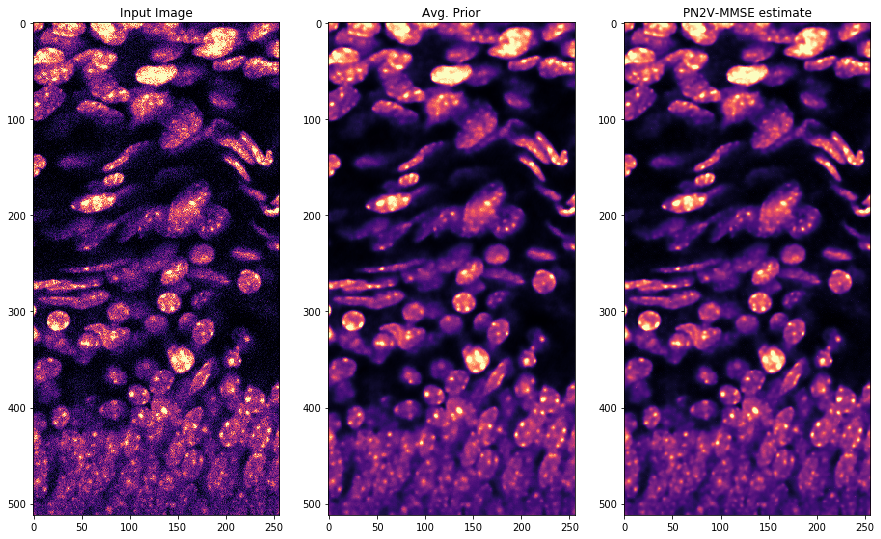

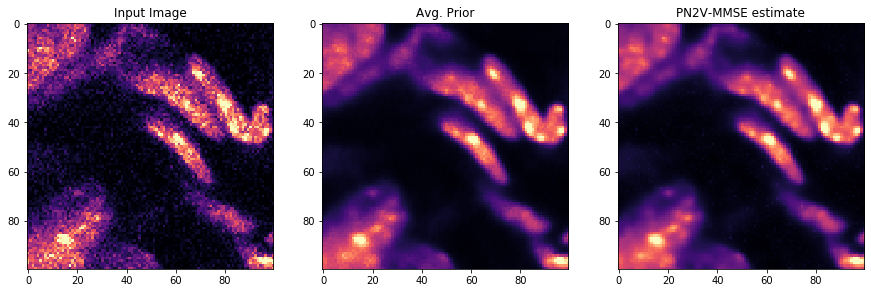

Avg PSNR Prior: 35.943422379980376 +-(2SEM) 0.008528182625866972
Avg PSNR MMSE: 36.4377303899609 +-(2SEM) 0.009895710328533074


In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=PSNR(gt, mseEst,rangePSNR )
    psnrPrior=PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )